In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd

In [2]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()
1

1

In [3]:
dataset = 'airquality' #choose 'healthcare' or 'airquality'
datafolder = 'pm25_outsample_20250201_170340'#'pretrained' # set the folder name
nsample = 100 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

if dataset == 'airquality':
    path = 'data/pm25/pm25_meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    train_std_cuda = torch.from_numpy(train_std).cuda()
    train_mean_cuda = torch.from_numpy(train_mean).cuda()
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples*train_std_cuda+train_mean_cuda)

In [4]:

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

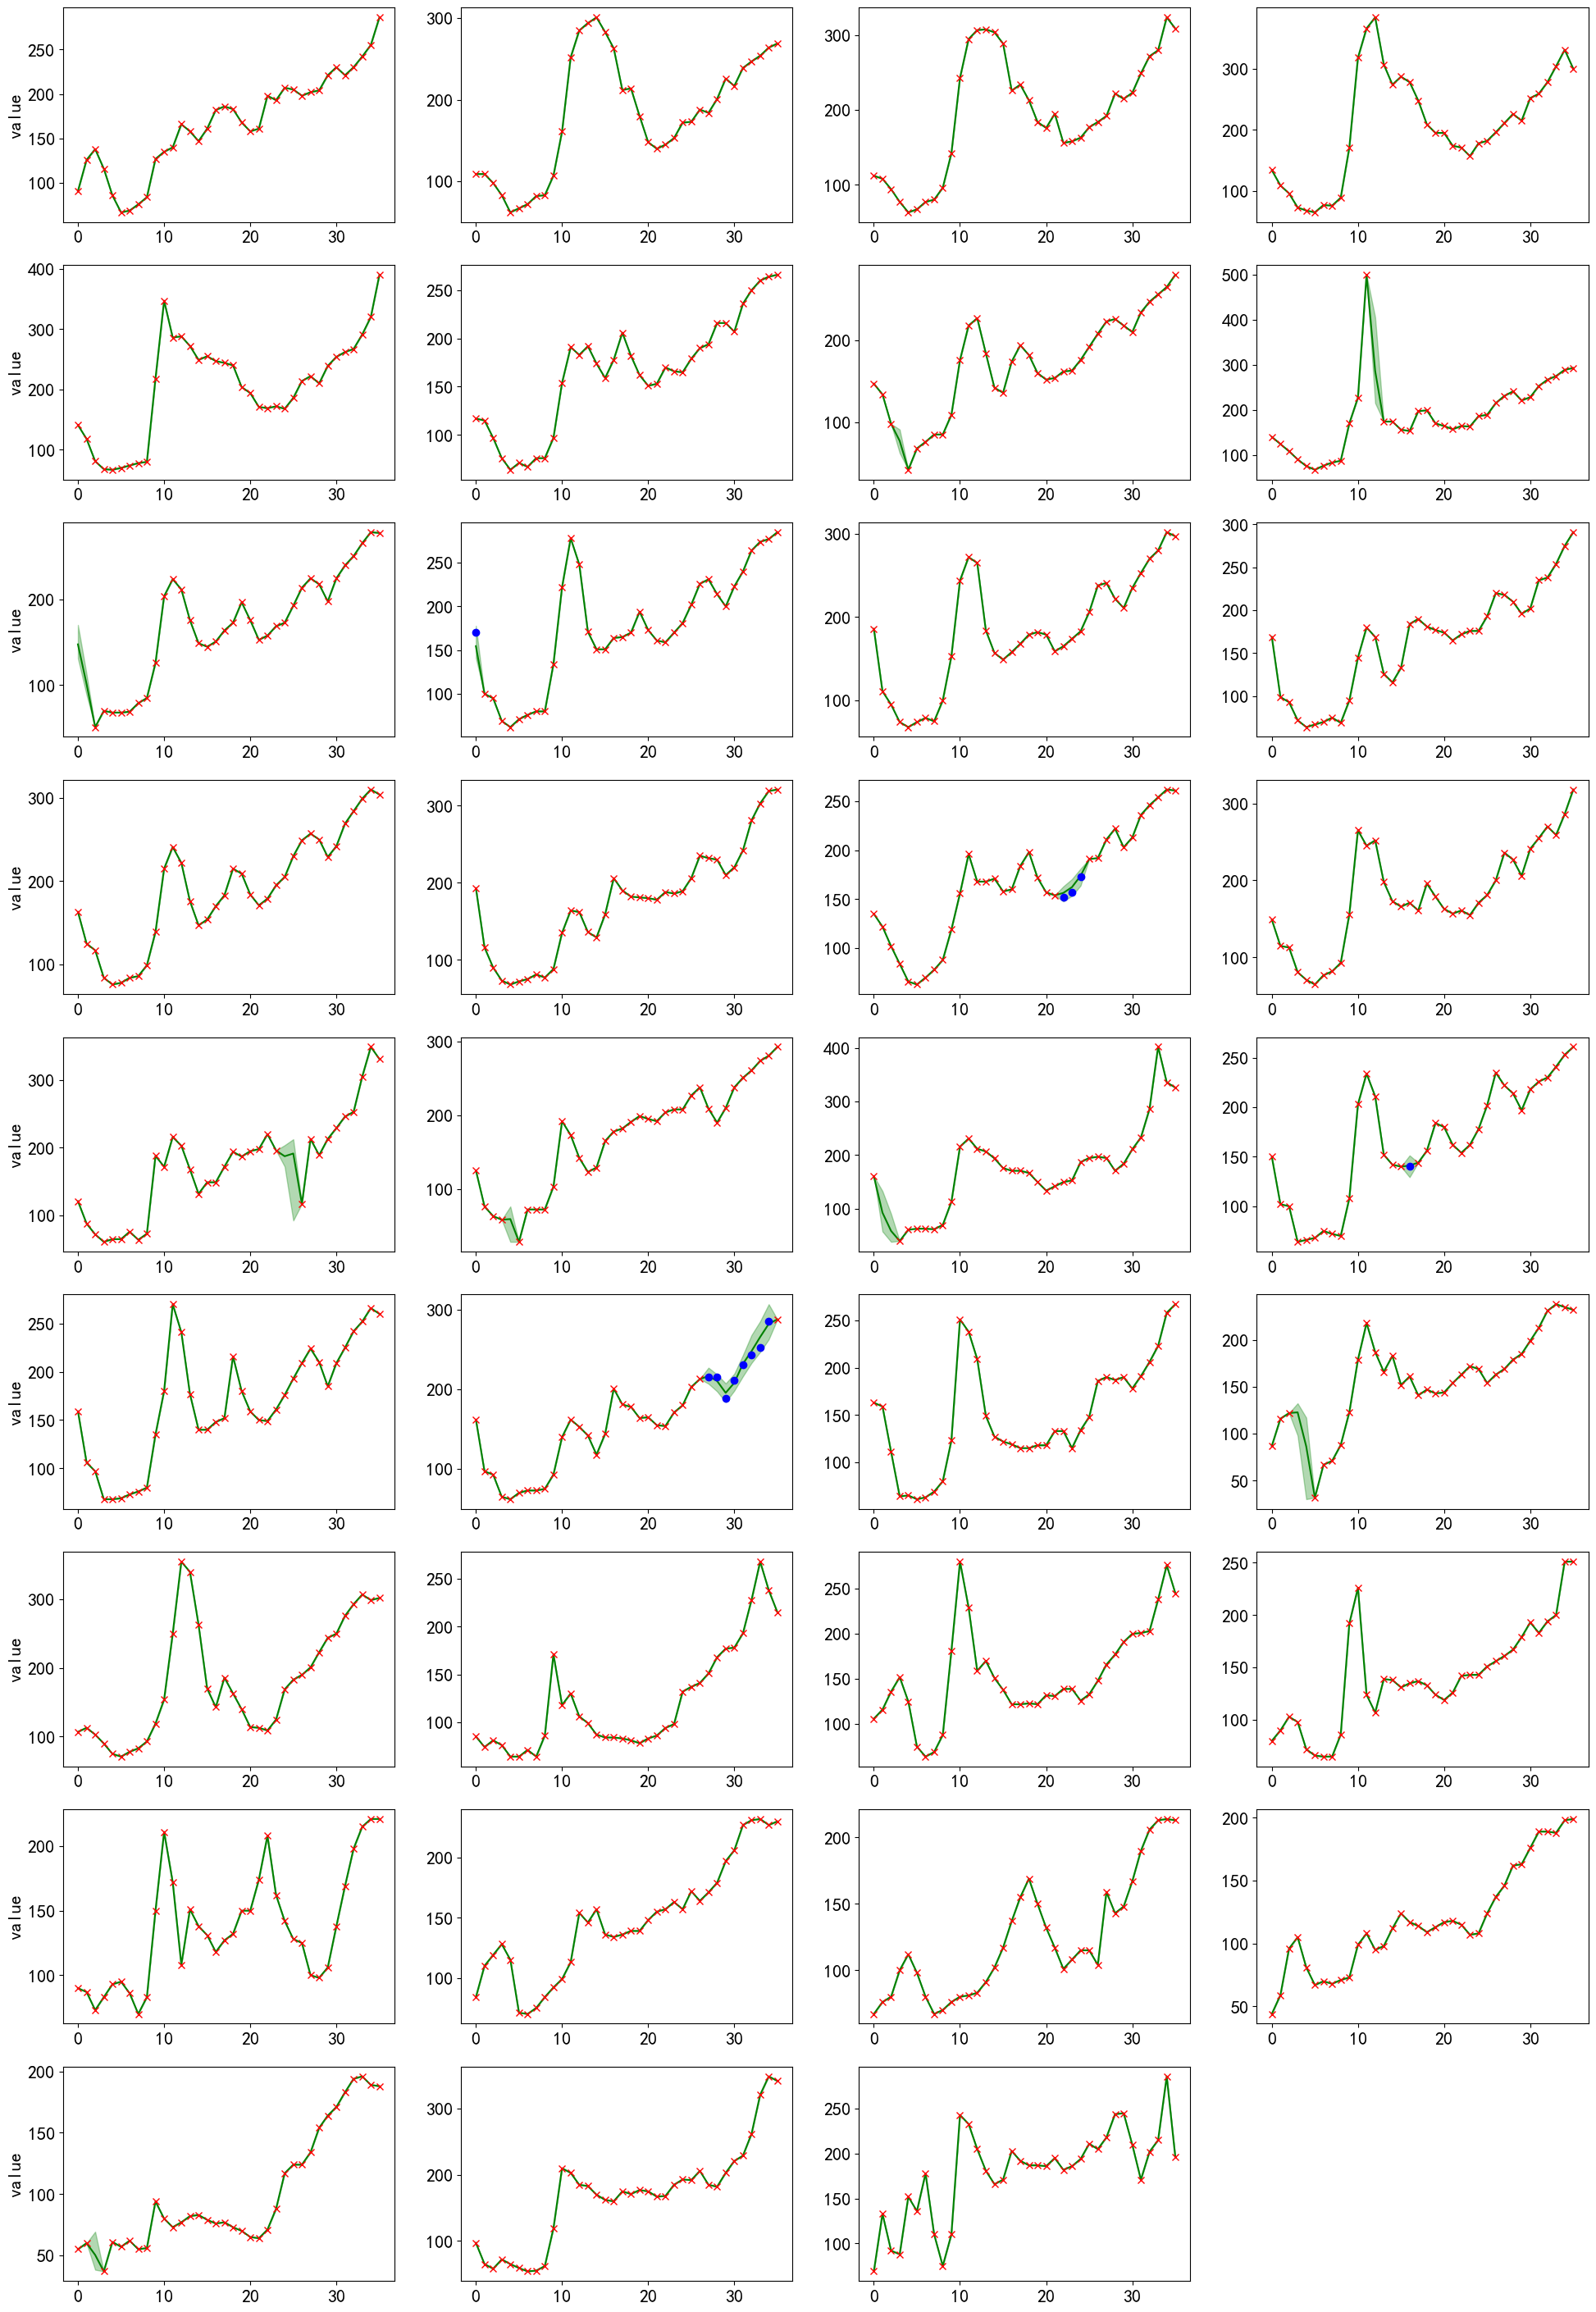

In [5]:
###healthcare###
dataind = 3 #change to visualize a different time-series sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


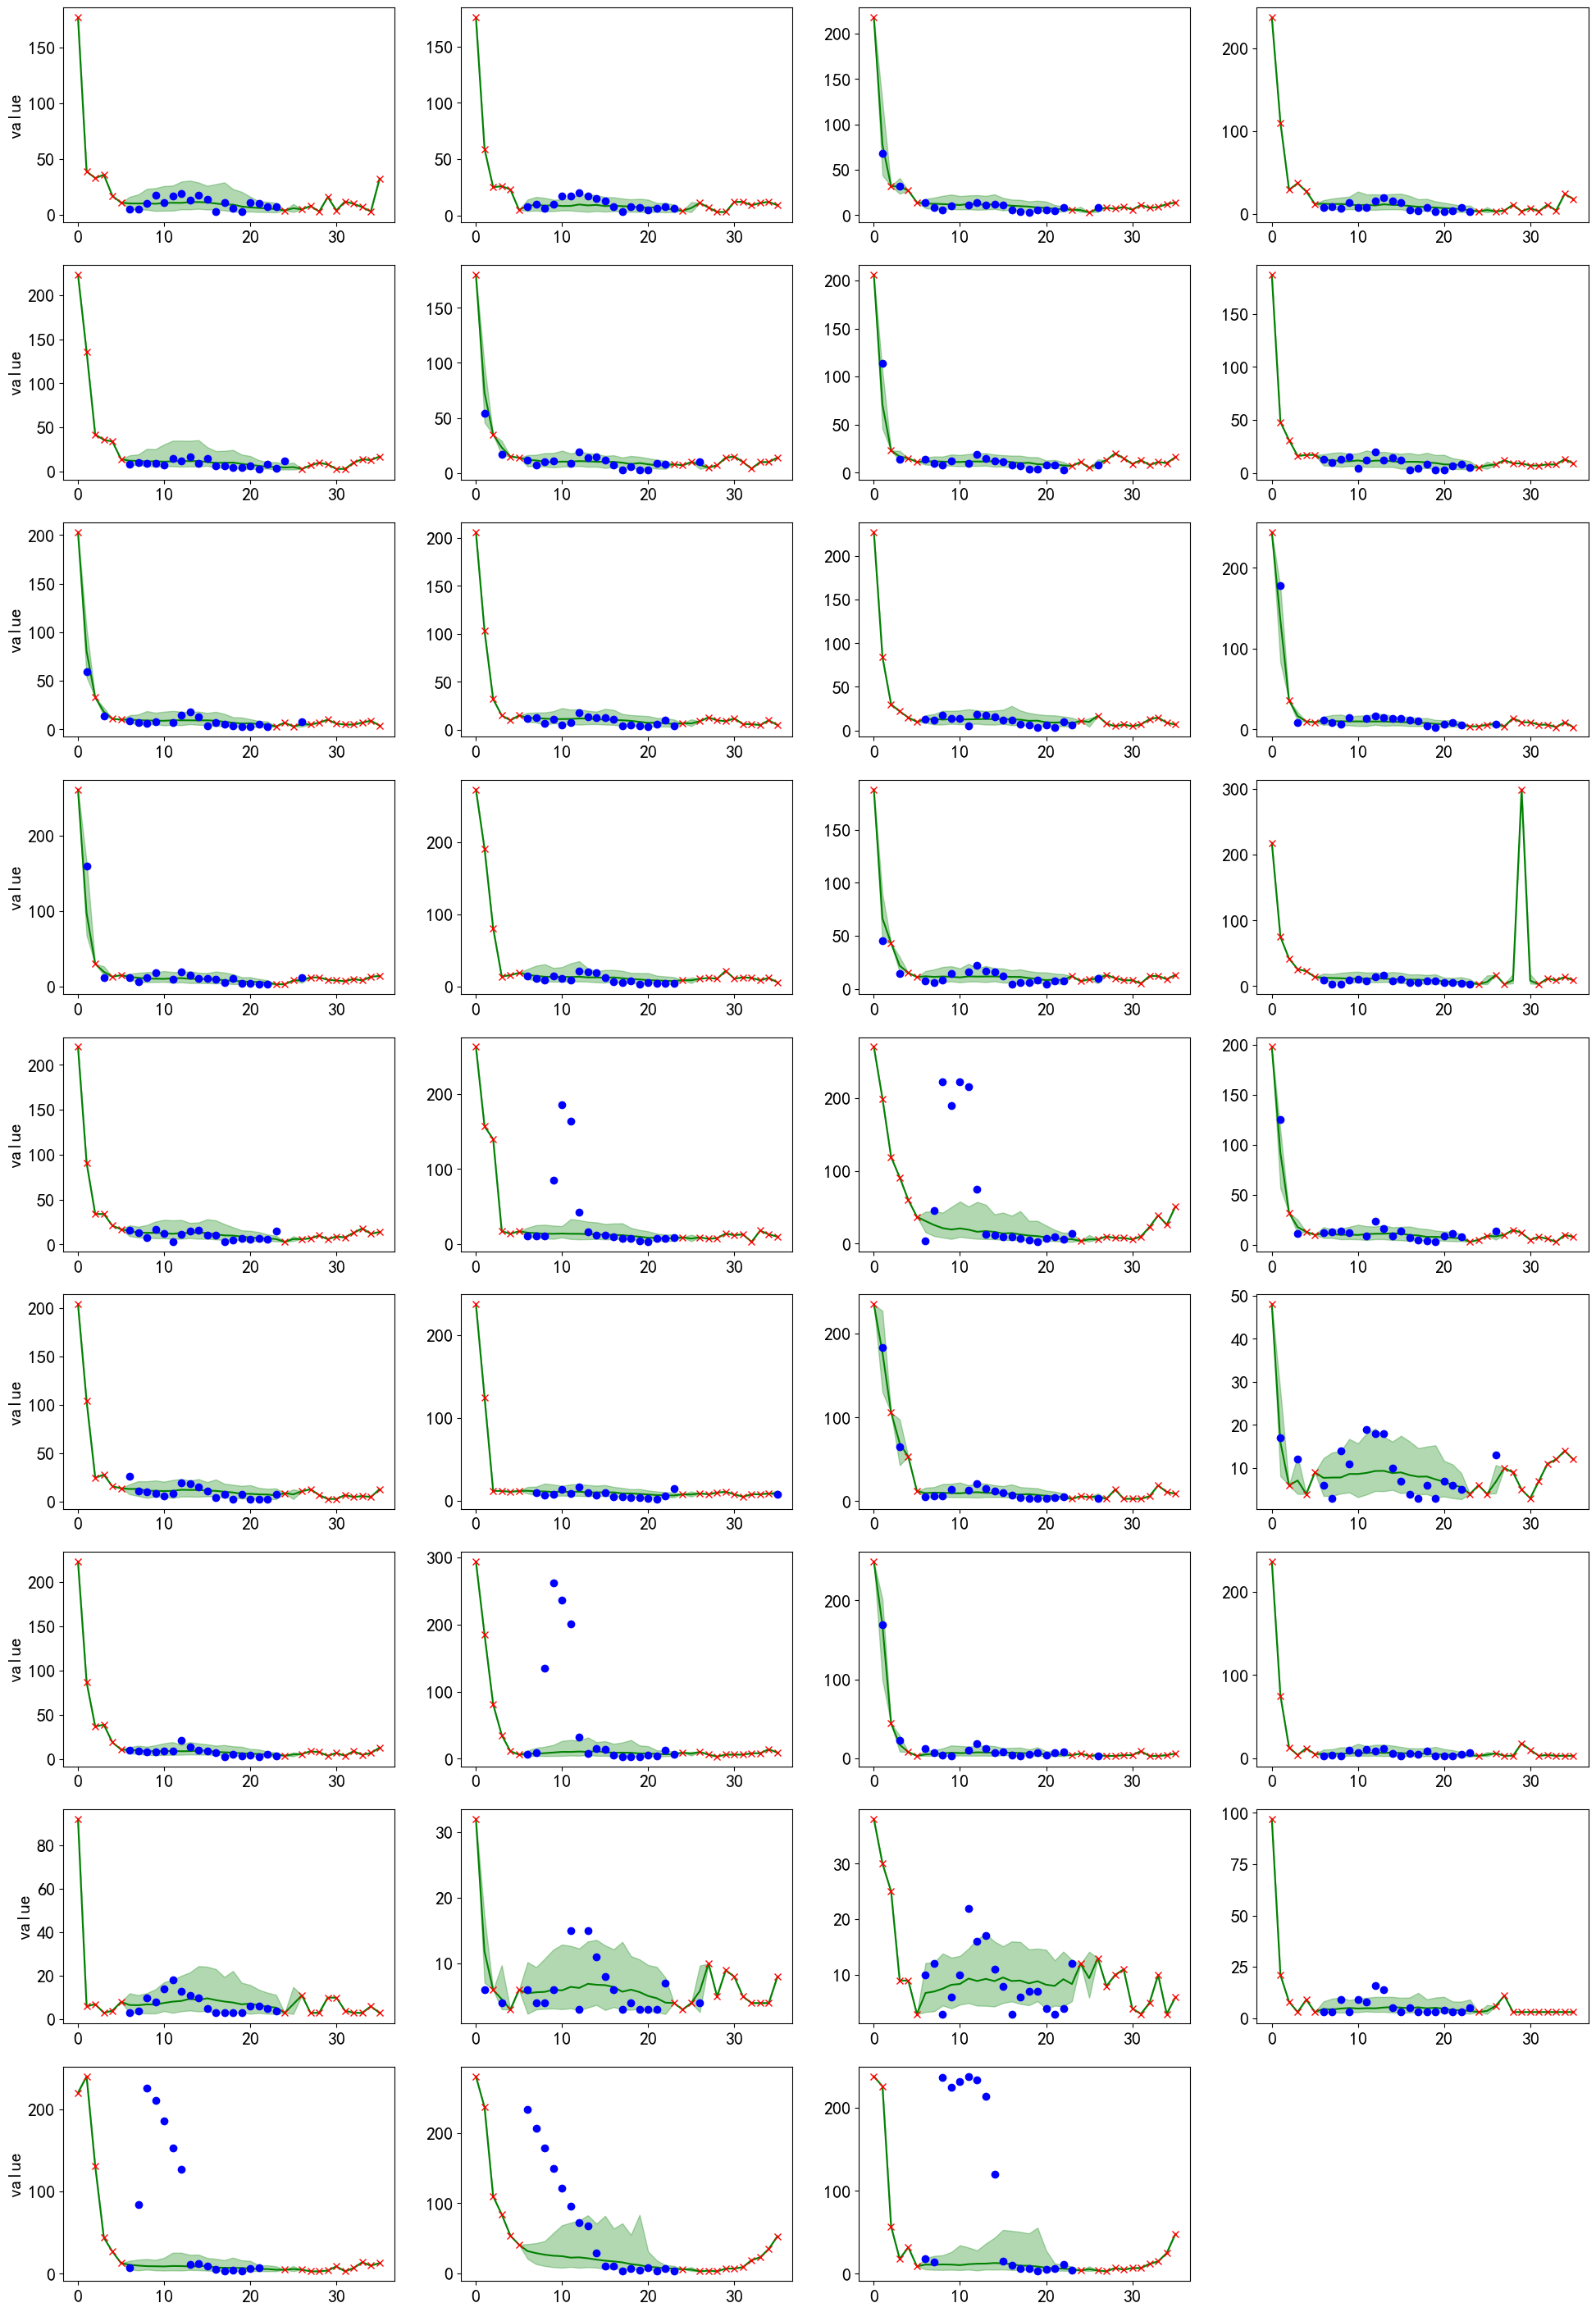

In [7]:
###airquality###
dataind = 5 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
# plt.savefig('prediction_7475_7511.png')

In [37]:
k=0
list_mae = []
for k in range(36):
    mask = all_evalpoint_np[:,:,k]!=0
    MAE = np.abs(all_target_np[:,:,k][mask] - quantiles_imp[2][:,:,k][mask]).mean()
    print(f'{k}: {(MAE-train_mean[k])/train_std[k]}')
    # su += (MAE-train_mean[k])/train_std[k]
    list_mae.append(MAE)

0: -1.0125942514465869
1: -0.938116987714616
2: -1.0395058541728484
3: -0.9937715299583636
4: -0.9848706670890134
5: -1.008350308096101
6: -1.0224930751100374
7: -1.0257395352411336
8: -0.9996793493728912
9: -1.0238219208464605
10: -1.0767323087927045
11: -0.9684311261253618
12: -0.9838028228872439
13: -0.9530647923255853
14: -1.0419655838205577
15: -1.0174906421752867
16: -0.978910899283684
17: -1.0160470776156723
18: -0.9809034739353849
19: -1.011816093507843
20: -1.0416858331141037
21: -0.9859542331876554
22: -0.9660852536285333
23: -0.8970340609315179
24: -0.9678964473267399
25: -0.9584889457940254
26: -0.9504456183209926
27: -0.8677829832209977
28: -0.9244362702396802
29: -0.8482069464177244
30: -0.8942042321421052
31: -0.8187404027476142
32: -0.9947640209384971
33: -0.9681382856066166
34: -0.9474970279486129
35: -0.9943005358385988


In [38]:
mask = all_given_np[:,:,k]!=0
np.mean((all_target_np[:,:,k][mask] - quantiles_imp[2][:,:,k][mask])**2)

0.0

In [39]:
dd = np.std(samples.cpu().numpy().transpose(1,0,2,3)*all_evalpoint_np,axis=0)

In [40]:
dd.mean()

1.8610185777952108

In [41]:
all_evalpoint_np.shape, samples.cpu().numpy().transpose(1,0,2,3).shape

((82, 36, 36), (100, 82, 36, 36))

6.600476029044838


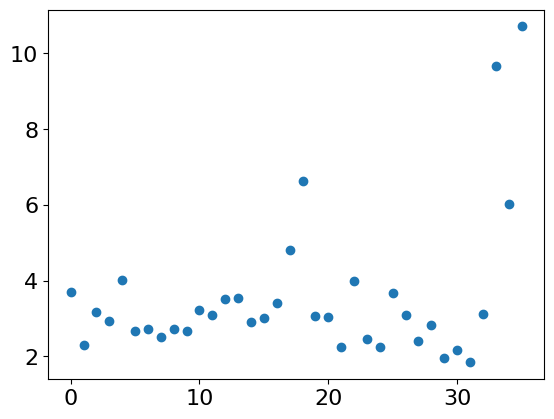

In [42]:
ddd = samples.cpu().numpy().transpose(1,0,2,3)*all_evalpoint_np
ddd[0,5,0,:] = 170



print(np.std(ddd,axis=0)[5,20,0])
np.std(ddd[:,5,20,0])


# ddd.shape
plt.plot(np.mean(np.std(ddd, axis=0), axis=1)[5],'o')

In [43]:
np.mean(np.std(ddd, axis=0))

1.8667485189980608

In [44]:
ddd.shape

(100, 82, 36, 36)

In [45]:
std_1 = np.mean(np.std(ddd[:,:,:,[2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]], axis=0))
std_2 = np.mean(np.std(ddd[:,:,:,[0,  1, 22, 23, 24, 26, 27, 28, 29, 30, 31]], axis=0))
std_3 = np.mean(np.std(ddd[:,:,:,[25, 32, 33, 34, 35]], axis=0))

print(std_1, std_2, std_3)

1.7450933106851958 1.7211573865359315 2.6736698436662056
